### ตรวจสอบอุปกรณ์ GPU ก่อนเริ่มทำการ Train Models

In [ ]:
import torch
print(torch.__version__)
print(torch.cuda.is_available())
print(torch.cuda.get_device_name(0) if torch.cuda.is_available() else "No GPU detected")


### แปลงทุกไฟล์ในทุก split (train/val/test) จาก polygon เป็น bbox

In [ ]:
import os

def convert_polygon_to_bbox(txt_path):
    with open(txt_path, "r") as f:
        lines = f.readlines()

    new_lines = []
    for line in lines:
        parts = list(map(float, line.strip().split()))
        cls = int(parts[0])
        if len(parts) > 5:  # polygon
            xs = parts[1::2]
            ys = parts[2::2]
            x_min, x_max = min(xs), max(xs)
            y_min, y_max = min(ys), max(ys)
            x_c = (x_min + x_max) / 2
            y_c = (y_min + y_max) / 2
            w = x_max - x_min
            h = y_max - y_min
            new_line = f"{cls} {x_c:.6f} {y_c:.6f} {w:.6f} {h:.6f}\n"
        else:
            new_line = line
        new_lines.append(new_line)

    with open(txt_path, "w") as f:
        f.writelines(new_lines)

base_dir = r"D:\MD\model_durian\dataset"
for split in ["train", "valid", "test"]:
    label_dir = os.path.join(base_dir, split, "labels")
    for file in os.listdir(label_dir):
        if file.endswith(".txt"):
            convert_polygon_to_bbox(os.path.join(label_dir, file))

print("Done")


### ลองดูตัวอย่างภาพแต่ละ class


📂 Showing samples from Train set...


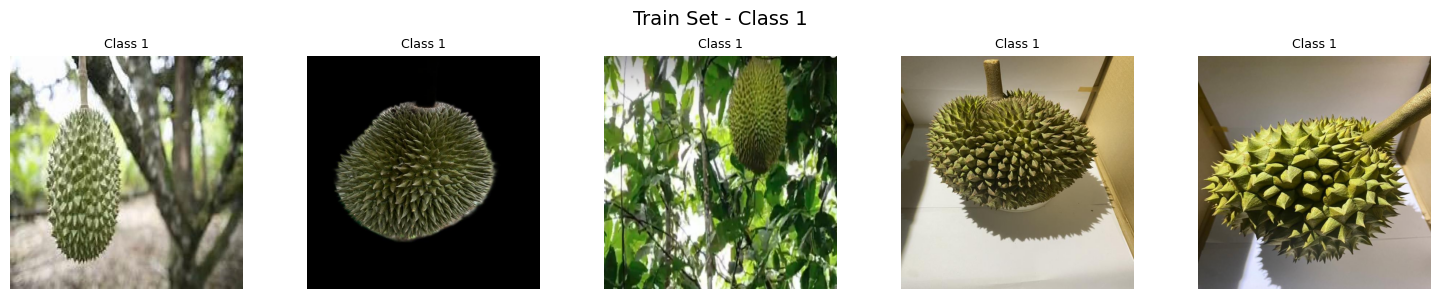

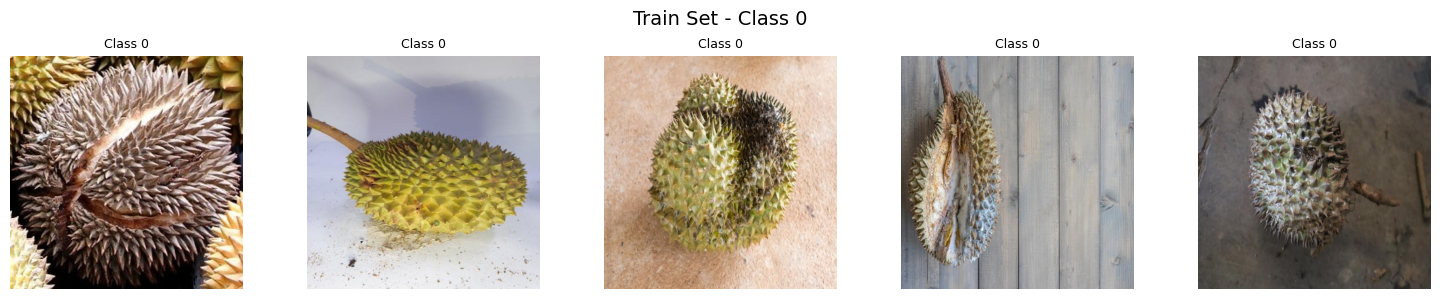

In [6]:
import os
import random
import cv2
import matplotlib.pyplot as plt


base_dir = r"D:\MD\model_durian\dataset"

sets = {
    "Train": os.path.join(base_dir, "train"),
}


def show_samples_by_class(set_name, base_path, n_per_class=5):
    img_dir = os.path.join(base_path, "images")
    label_dir = os.path.join(base_path, "labels")

    # อ่าน label ทั้งหมด
    class_to_files = {}

    for file in os.listdir(label_dir):
        if not file.endswith(".txt"):
            continue
        label_path = os.path.join(label_dir, file)
        with open(label_path, "r") as f:
            lines = f.readlines()
            if not lines:
                continue
            # ใช้เฉพาะคลาสแรก (ถ้ามีหลายอันในภาพเดียว)
            first_cls = int(lines[0].split()[0])
            class_to_files.setdefault(first_cls, []).append(file.replace(".txt", ".jpg"))

    # วาดภาพแต่ละคลาส
    for cls_id, files in class_to_files.items():
        samples = random.sample(files, min(n_per_class, len(files)))

        plt.figure(figsize=(15, 3))
        for i, fname in enumerate(samples):
            img_path = os.path.join(img_dir, fname)
            if not os.path.exists(img_path):
                continue
            img = cv2.imread(img_path)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            plt.subplot(1, n_per_class, i + 1)
            plt.imshow(img)
            plt.title(f"Class {cls_id}", fontsize=9)
            plt.axis("off")
        plt.suptitle(f"{set_name} Set - Class {cls_id}", fontsize=14)
        plt.tight_layout()
        plt.show()


for name, path in sets.items():
    print(f"\n📂 Showing samples from {name} set...")
    show_samples_by_class(name, path, n_per_class=5)


### ดูจำนวนข้อมูลในแต่ class

In [13]:
import os
from collections import Counter, defaultdict

base_dir = r"D:\MD\model_durian\dataset"
sets = {
    "Train": os.path.join(base_dir, "train", "labels"),
    "Validation": os.path.join(base_dir, "valid", "labels"),
    "Test": os.path.join(base_dir, "test", "labels")
}
class_names = ["defective", "immature", "mature"]

def count_labels_images(label_dir):
    label_count = Counter()
    img_per_class = defaultdict(set)

    for file in os.listdir(label_dir):
        if not file.endswith(".txt"):
            continue
        with open(os.path.join(label_dir, file)) as f:
            for line in f:
                cls_id = int(line.split()[0])
                label_count[cls_id] += 1
                img_per_class[cls_id].add(file)

    img_count = {cls: len(imgs) for cls, imgs in img_per_class.items()}
    return label_count, img_count

for name, path in sets.items():
    labels, images = count_labels_images(path)
    print(f"\n🟩 {name}")
    for i, cname in enumerate(class_names):
        print(f" - {cname:<10s}: {images.get(i,0)} images | {labels.get(i,0)} labels")



🟩 Train
 - defective : 162 images | 201 labels
 - immature  : 737 images | 1042 labels
 - mature    : 907 images | 1318 labels

🟩 Validation
 - defective : 17 images | 17 labels
 - immature  : 106 images | 173 labels
 - mature    : 135 images | 189 labels

🟩 Test
 - defective : 47 images | 50 labels
 - immature  : 216 images | 306 labels
 - mature    : 254 images | 376 labels


### Train Model1 ไม่ Augmentation

In [ ]:
from ultralytics import YOLO

model = YOLO('yolov8n.pt')

model.train(
    data=r"D:\MD\model_durian\data.yaml",
    epochs=75,
    imgsz=640,
    batch=8,
    name="durian_model1",
    device=0
)



### ดูผลลัพธ์ของ durian_model1

In [35]:
from ultralytics import YOLO

# โหลดโมเดล
model = YOLO(r"D:\MD\model_durian\runs\detect\durian_model1\weights\best.pt")

# ประเมินผล
results = model.val(data=r"D:\MD\model_durian\data.yaml", split="test", device=0)

# ดึงค่า Precision และ Recall เฉลี่ยทั้งหมด
precision = results.box.p.mean()
recall = results.box.r.mean()

# คำนวณ Accuracy โดยประมาณ
accuracy = (precision + recall) / 2

print(f"Precision: {precision:.3f}")
print(f"Recall: {recall:.3f}")
print(f"Approx. Accuracy: {accuracy:.3f}")
print(f"mAP50: {results.box.map50:.3f}")


Ultralytics 8.3.208  Python-3.10.18 torch-2.5.1+cu121 CUDA:0 (NVIDIA GeForce RTX 3060 Laptop GPU, 6144MiB)
Model summary (fused): 72 layers, 3,006,233 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.00.0 ms, read: 1476.5697.3 MB/s, size: 60.3 KB)
val: Scanning D:\MD\model_durian\dataset\test\labels.cache... 509 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 509/509 506.6Kit/s 0.0s
WARNING Box and segment counts should be equal, but got len(segments) = 70, len(boxes) = 732. To resolve this only boxes will be used and all segments will be removed. To avoid this please supply either a detect or segment dataset, not a detect-segment mixed dataset.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 32/32 6.7it/s 4.8s0.1s
                   all        509        732       0.89      0.723      0.822      0.727
             defective         47         50       0.86       0.78      0.801      0.677
             

### แสดงภาพ Confusion Matrix ของ durian_model1

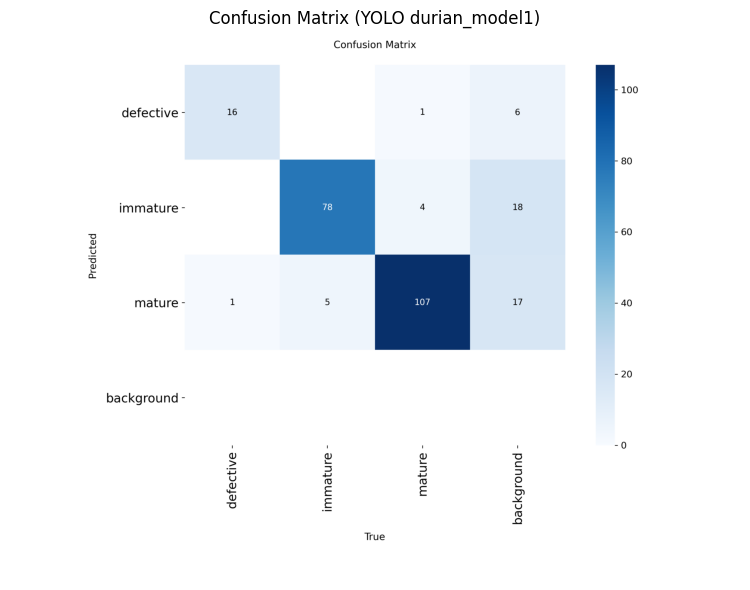

In [34]:
import cv2
import matplotlib.pyplot as plt

cm_path = r"D:\MD\model_durian\runs\detect\durian_model1\confusion_matrix.png"

img = cv2.imread(cm_path)

img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(8, 6))
plt.imshow(img)
plt.title("Confusion Matrix (YOLO durian_model1)")
plt.axis("off")
plt.tight_layout()
plt.show()


### ลองดูผลลัพธ์ ที่ทำนาย

In [16]:
%matplotlib inline


image 1/1 D:\MD\model_durian\dataset\test\images\48_jpg.rf.d101dfea4bfa3bdcb658a2955c9ed264.jpg: 640x640 2 immatures, 6.5ms
Speed: 2.5ms preprocess, 6.5ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


C:\Users\WATCHARAKORN_SRIDEE\AppData\Local\Temp\ipykernel_23252\3620750985.py:57: UserWarning: Glyph 128309 (\N{LARGE BLUE CIRCLE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\WATCHARAKORN_SRIDEE\AppData\Local\Temp\ipykernel_23252\3620750985.py:57: UserWarning: Glyph 128994 (\N{LARGE GREEN CIRCLE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()


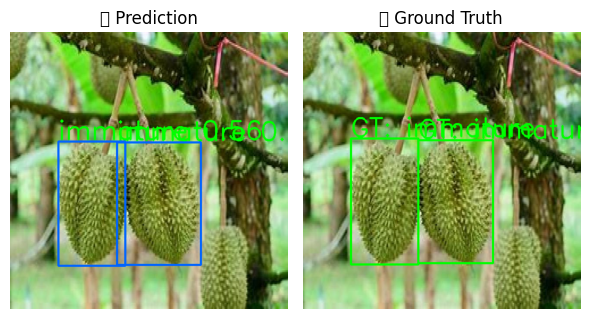

In [33]:
from ultralytics import YOLO
import cv2
import matplotlib.pyplot as plt
import os

model = YOLO(r"D:\MD\model_durian\runs\detect\durian_model1\weights\best.pt")

img_path = r"D:\MD\model_durian\dataset\test\images\48_jpg.rf.d101dfea4bfa3bdcb658a2955c9ed264.jpg"

label_path = img_path.replace("images", "labels").replace(".jpg", ".txt")


results = model.predict(source=img_path, device=0, conf=0.5, save=False)
r = results[0]
im_pred = r.orig_img.copy() 
H, W = im_pred.shape[:2]


for box in r.boxes:
    cls_id = int(box.cls[0])
    conf = float(box.conf[0])
    x1, y1, x2, y2 = map(int, box.xyxy[0])
    label = f"{model.names[cls_id]} {conf:.2f}"
    cv2.rectangle(im_pred, (x1, y1), (x2, y2), (255, 100, 0), 3)
    cv2.putText(im_pred, label, (x1, y1 - 5), cv2.FONT_HERSHEY_SIMPLEX, 2, (0, 255, 0), 3)

im_gt = r.orig_img.copy()
if os.path.exists(label_path):
    with open(label_path, "r") as f:
     for line in f:
         parts = list(map(float, line.strip().split()))
         if len(parts) < 5:
             continue  # ข้ามถ้าข้อมูลไม่ครบ
         cls, x, y, w, h = parts[:5]  # ใช้แค่ 5 ตัวแรก
         x1 = int((x - w / 2) * W)
         y1 = int((y - h / 2) * H)
         x2 = int((x + w / 2) * W)
         y2 = int((y + h / 2) * H)
         label = f"GT: {model.names[int(cls)]}"
         cv2.rectangle(im_gt, (x1, y1), (x2, y2), (0, 255, 0), 3)
         cv2.putText(im_gt, label, (x1, y1 - 5),
                     cv2.FONT_HERSHEY_SIMPLEX, 2, (0, 255, 0), 3)


plt.figure(figsize=(6, 6))

plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(im_pred, cv2.COLOR_BGR2RGB))
plt.title("🔵 Prediction")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(cv2.cvtColor(im_gt, cv2.COLOR_BGR2RGB))
plt.title("🟢 Ground Truth")
plt.axis("off")

plt.tight_layout()
plt.show()


### ลองนำ Model1 ก่อน Augmentation ทำนายข้อมูลจากสถานที่จริงที่เป็น Class mature พบว่า Model1 ทำนายผิด ผู้วิจัยตั้งข้อสังเกตุว่าสาเหตุมาจากแสงรบกวนจากสถานที่ จึงทำการทดลอง Augmentation แสงใน Model ถัดไป


image 1/1 D:\MD\model_durian\imgtest\S__3022859.jpg: 640x480 1 immature, 7.6ms
Speed: 1.9ms preprocess, 7.6ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 480)


C:\Users\WATCHARAKORN_SRIDEE\AppData\Local\Temp\ipykernel_23252\1410844945.py:57: UserWarning: Glyph 128309 (\N{LARGE BLUE CIRCLE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\WATCHARAKORN_SRIDEE\AppData\Local\Temp\ipykernel_23252\1410844945.py:57: UserWarning: Glyph 128994 (\N{LARGE GREEN CIRCLE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
d:\FM\anaconda\envs\dl_565\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128309 (\N{LARGE BLUE CIRCLE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
d:\FM\anaconda\envs\dl_565\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128994 (\N{LARGE GREEN CIRCLE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


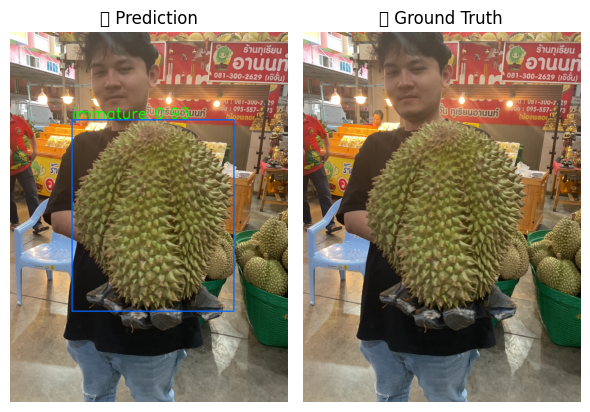

In [32]:
from ultralytics import YOLO
import cv2
import matplotlib.pyplot as plt
import os

model = YOLO(r"D:\MD\model_durian\runs\detect\durian_model1\weights\best.pt")

img_path = r"D:\MD\model_durian\imgtest\S__3022859.jpg"

label_path = img_path.replace("images", "labels").replace(".jpg", ".txt")


results = model.predict(source=img_path, device=0, conf=0.5, save=False)
r = results[0]
im_pred = r.orig_img.copy() 
H, W = im_pred.shape[:2]


for box in r.boxes:
    cls_id = int(box.cls[0])
    conf = float(box.conf[0])
    x1, y1, x2, y2 = map(int, box.xyxy[0])
    label = f"{model.names[cls_id]} {conf:.2f}"
    cv2.rectangle(im_pred, (x1, y1), (x2, y2), (255, 100, 0), 3)
    cv2.putText(im_pred, label, (x1, y1 - 5), cv2.FONT_HERSHEY_SIMPLEX, 2, (0, 255, 0), 3)

im_gt = r.orig_img.copy()
if os.path.exists(label_path):
    with open(label_path, "r") as f:
     for line in f:
         parts = list(map(float, line.strip().split()))
         if len(parts) < 5:
             continue  # ข้ามถ้าข้อมูลไม่ครบ
         cls, x, y, w, h = parts[:5]  # ใช้แค่ 5 ตัวแรก
         x1 = int((x - w / 2) * W)
         y1 = int((y - h / 2) * H)
         x2 = int((x + w / 2) * W)
         y2 = int((y + h / 2) * H)
         label = f"GT: {model.names[int(cls)]}"
         cv2.rectangle(im_gt, (x1, y1), (x2, y2), (0, 255, 0), 3)
         cv2.putText(im_gt, label, (x1, y1 - 5),
                     cv2.FONT_HERSHEY_SIMPLEX, 2, (0, 255, 0), 3)


plt.figure(figsize=(6, 6))

plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(im_pred, cv2.COLOR_BGR2RGB))
plt.title("🔵 Prediction")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(cv2.cvtColor(im_gt, cv2.COLOR_BGR2RGB))
plt.title("🟢 Ground Truth")
plt.axis("off")

plt.tight_layout()
plt.show()


### ลองแสดงภาพและปรับ parameter เพื่อดูว่า Augmentation ภาพจะถูกปรับอย่างไรบ้าง

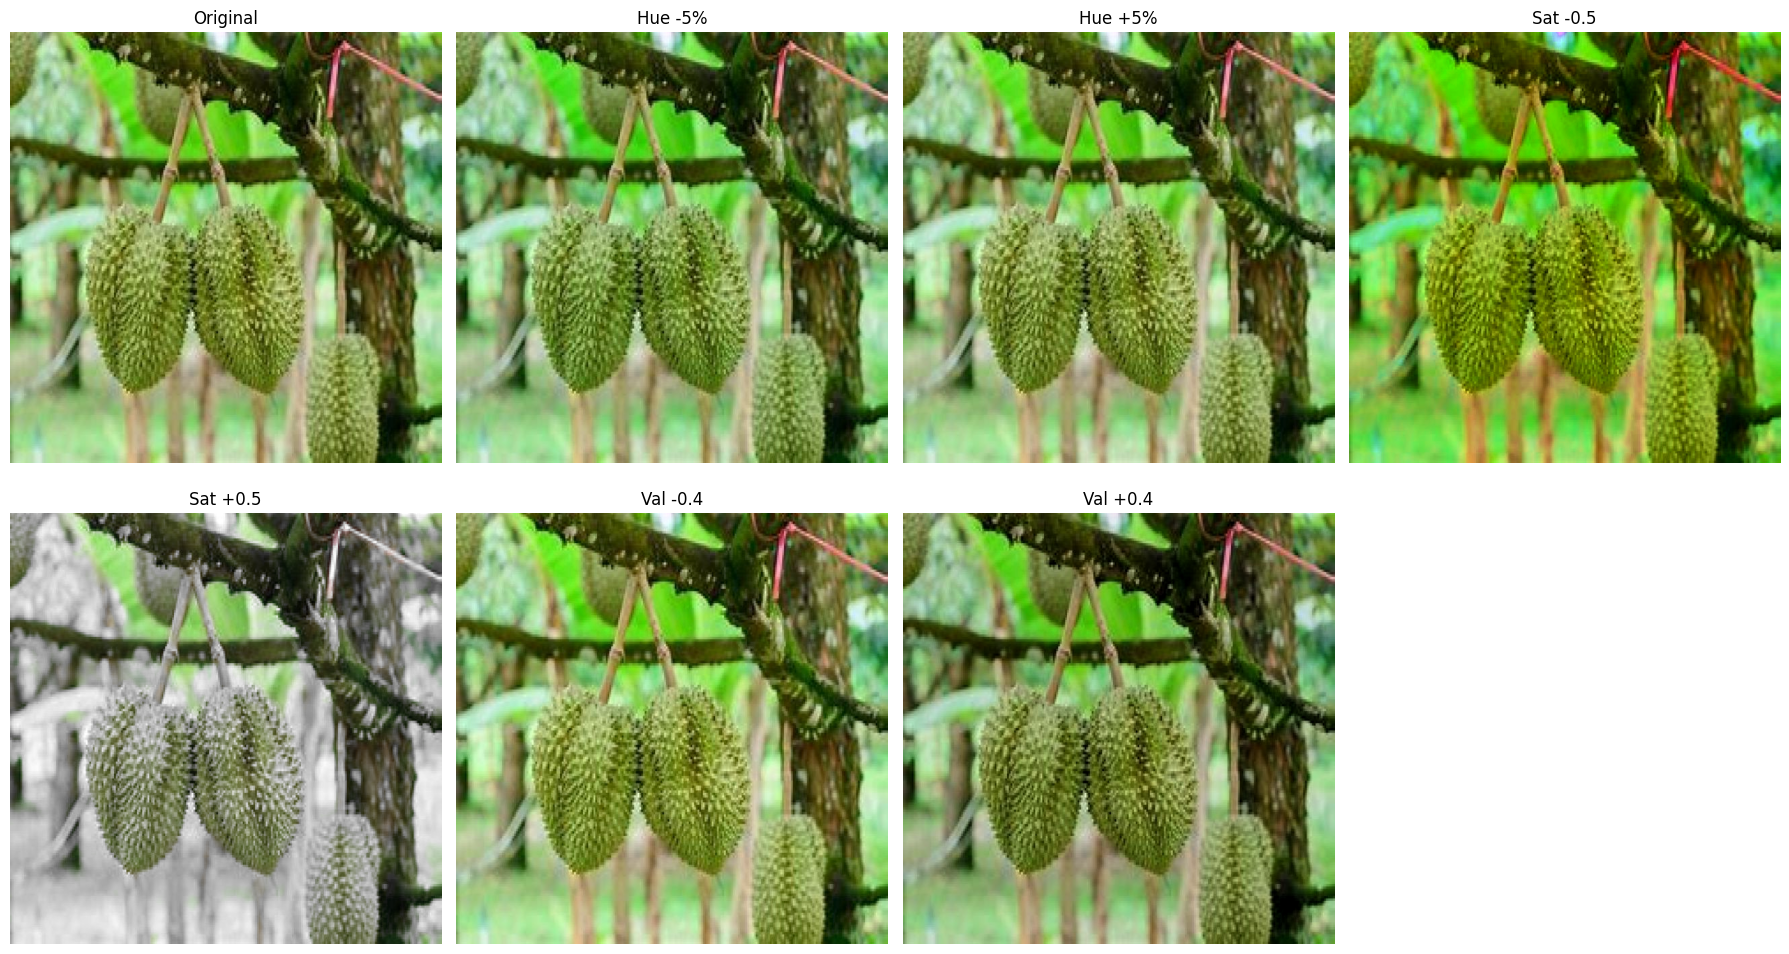

In [22]:
import cv2
import matplotlib.pyplot as plt
import albumentations as A

img_path = r"D:\MD\model_durian\dataset\test\images\48_jpg.rf.d101dfea4bfa3bdcb658a2955c9ed264.jpg"
image = cv2.imread(img_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# ---------- สร้างการแปลงสีตามแต่ละพารามิเตอร์ ----------

# Hue ±5%
hue_low = A.HueSaturationValue(hue_shift_limit=-0.05*180, sat_shift_limit=0, val_shift_limit=0, p=1)
hue_high = A.HueSaturationValue(hue_shift_limit=+0.05*180, sat_shift_limit=0, val_shift_limit=0, p=1)

# Saturation ±0.8
sat_low = A.HueSaturationValue(hue_shift_limit=0, sat_shift_limit=-0.5*255, val_shift_limit=0, p=1)
sat_high = A.HueSaturationValue(hue_shift_limit=0, sat_shift_limit=+0.5*255, val_shift_limit=0, p=1)

# Value ±0.8
val_low = A.HueSaturationValue(hue_shift_limit=0, sat_shift_limit=0, val_shift_limit=-0.4*255, p=1)
val_high = A.HueSaturationValue(hue_shift_limit=0, sat_shift_limit=0, val_shift_limit=+0.4*255, p=1)


img_hue_low = hue_low(image=image)["image"]
img_hue_high = hue_high(image=image)["image"]
img_sat_low = sat_low(image=image)["image"]
img_sat_high = sat_high(image=image)["image"]
img_val_low = val_low(image=image)["image"]
img_val_high = val_high(image=image)["image"]


titles = [
    "Original",
    "Hue -5%",
    "Hue +5%",
    "Sat -0.5",
    "Sat +0.5",
    "Val -0.4",
    "Val +0.4"
]
images = [
    image,
    img_hue_low, img_hue_high,
    img_sat_low, img_sat_high,
    img_val_low, img_val_high
]

plt.figure(figsize=(18, 10))
for i, (img, title) in enumerate(zip(images, titles), start=1):
    plt.subplot(2, 4, i)
    plt.imshow(img)
    plt.title(title)
    plt.axis("off")

plt.tight_layout()
plt.show()


### Train durian_model2 Augment

In [ ]:
from ultralytics import YOLO

model = YOLO("yolov8n.pt")

model.train(
    data=r"D:\MD\model_durian\data.yaml",
    epochs=75,
    imgsz=640,
    batch=8,
    name="durian_model2",
    device=0,
    augment=True,
    hsv_h = 0.05,    # เฉดสี ±5%
    hsv_s = 0.5,    # ความอิ่มสี ±50%
    hsv_v = 0.4,     # ความสว่าง ±40%
    degrees=7.0,     # หมุนเล็กน้อย
    translate=0.1,   # ขยับภาพ
    scale=0.9,       # ย่อขยาย
    shear=3.0,       # บิดเฉียงเล็กน้อย
    fliplr=0.5,      # พลิกแนวนอน 50%
    flipud=0.2       # พลิกแนวตั้ง 20%
)


### ดูผลลัพธ์ durian_model2

In [31]:
from ultralytics import YOLO

# โหลดโมเดล
model = YOLO(r"D:\MD\model_durian\runs\detect\durian_model2\weights\best.pt")

# ประเมินผล
results = model.val(data=r"D:\MD\model_durian\data.yaml", split="test", device=0)

# ดึงค่า Precision และ Recall เฉลี่ยทั้งหมด
precision = results.box.p.mean()
recall = results.box.r.mean()

# คำนวณ Accuracy โดยประมาณ
accuracy = (precision + recall) / 2

print(f"Precision: {precision:.3f}")
print(f"Recall: {recall:.3f}")
print(f"Approx. Accuracy: {accuracy:.3f}")
print(f"mAP50: {results.box.map50:.3f}")


Ultralytics 8.3.208  Python-3.10.18 torch-2.5.1+cu121 CUDA:0 (NVIDIA GeForce RTX 3060 Laptop GPU, 6144MiB)
Model summary (fused): 72 layers, 3,006,233 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.00.0 ms, read: 1538.9700.8 MB/s, size: 67.9 KB)
val: Scanning D:\MD\model_durian\dataset\test\labels.cache... 509 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 509/509 508.8Kit/s 0.0s
WARNING Box and segment counts should be equal, but got len(segments) = 70, len(boxes) = 732. To resolve this only boxes will be used and all segments will be removed. To avoid this please supply either a detect or segment dataset, not a detect-segment mixed dataset.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 32/32 5.0it/s 6.3s0.2s
                   all        509        732      0.863      0.724      0.821      0.733
             defective         47         50      0.867       0.78      0.796      0.698
             

### แสดงภาพ Confusion Matrix ของ durian_model2

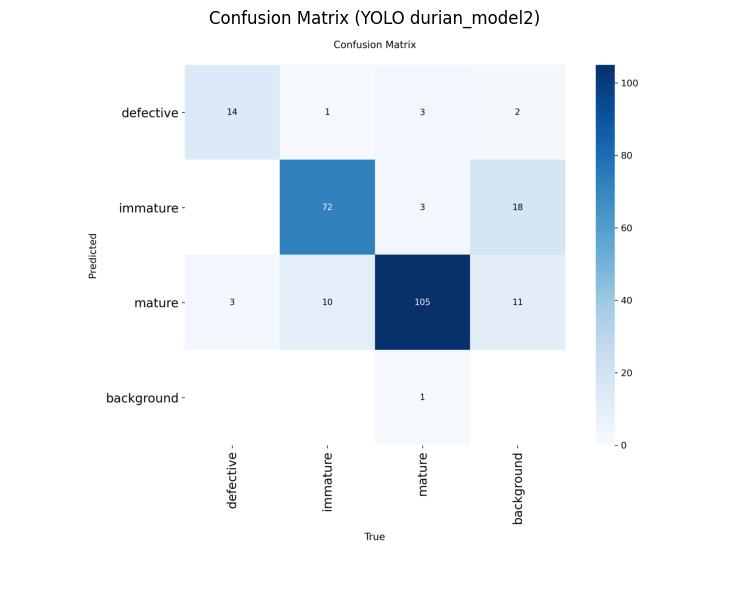

In [30]:
import cv2
import matplotlib.pyplot as plt

cm_path = r"D:\MD\model_durian\runs\detect\durian_model2\confusion_matrix.png"

img = cv2.imread(cm_path)

img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(8, 6))
plt.imshow(img)
plt.title("Confusion Matrix (YOLO durian_model2)")
plt.axis("off")
plt.tight_layout()
plt.show()


### จากผลลัพธ์ Model ทำนาย class จากภาพที่ถ่ายจากสถานที่จริงได้ถูกต้อง


image 1/1 D:\MD\model_durian\imgtest\S__3022859.jpg: 640x480 1 mature, 8.4ms
Speed: 2.3ms preprocess, 8.4ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 480)


C:\Users\WATCHARAKORN_SRIDEE\AppData\Local\Temp\ipykernel_23252\2437902056.py:57: UserWarning: Glyph 128309 (\N{LARGE BLUE CIRCLE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\WATCHARAKORN_SRIDEE\AppData\Local\Temp\ipykernel_23252\2437902056.py:57: UserWarning: Glyph 128994 (\N{LARGE GREEN CIRCLE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()


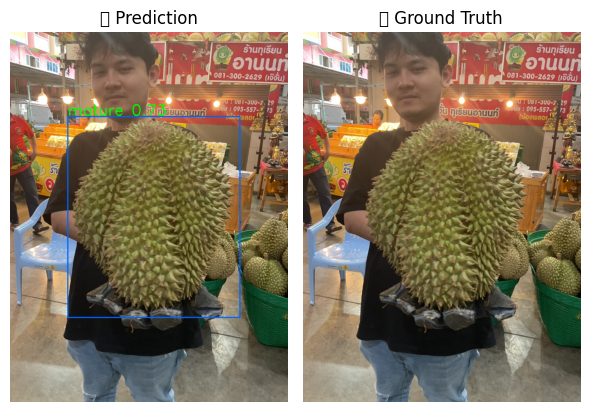

In [29]:
from ultralytics import YOLO
import cv2
import matplotlib.pyplot as plt
import os

model = YOLO(r"D:\MD\model_durian\runs\detect\durian_model2\weights\best.pt")

img_path = r"D:\MD\model_durian\imgtest\S__3022859.jpg"

label_path = img_path.replace("images", "labels").replace(".jpg", ".txt")


results = model.predict(source=img_path, device=0, conf=0.5, save=False)
r = results[0]
im_pred = r.orig_img.copy() 
H, W = im_pred.shape[:2]


for box in r.boxes:
    cls_id = int(box.cls[0])
    conf = float(box.conf[0])
    x1, y1, x2, y2 = map(int, box.xyxy[0])
    label = f"{model.names[cls_id]} {conf:.2f}"
    cv2.rectangle(im_pred, (x1, y1), (x2, y2), (255, 100, 0), 3)
    cv2.putText(im_pred, label, (x1, y1 - 5), cv2.FONT_HERSHEY_SIMPLEX, 2, (0, 255, 0), 3)

im_gt = r.orig_img.copy()
if os.path.exists(label_path):
    with open(label_path, "r") as f:
     for line in f:
         parts = list(map(float, line.strip().split()))
         if len(parts) < 5:
             continue  # ข้ามถ้าข้อมูลไม่ครบ
         cls, x, y, w, h = parts[:5]  # ใช้แค่ 5 ตัวแรก
         x1 = int((x - w / 2) * W)
         y1 = int((y - h / 2) * H)
         x2 = int((x + w / 2) * W)
         y2 = int((y + h / 2) * H)
         label = f"GT: {model.names[int(cls)]}"
         cv2.rectangle(im_gt, (x1, y1), (x2, y2), (0, 255, 0), 3)
         cv2.putText(im_gt, label, (x1, y1 - 5),
                     cv2.FONT_HERSHEY_SIMPLEX, 2, (0, 255, 0), 3)


plt.figure(figsize=(6, 6))

plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(im_pred, cv2.COLOR_BGR2RGB))
plt.title("🔵 Prediction")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(cv2.cvtColor(im_gt, cv2.COLOR_BGR2RGB))
plt.title("🟢 Ground Truth")
plt.axis("off")

plt.tight_layout()
plt.show()
